In [60]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.neighbors import NearestNeighbors as KNN
import torchaudio
import torch
import os
import re

In [2]:
PATH = "D:/Python/Audio/English/chiara_hacking_1_en.wav"

In [3]:
data, sr = torchaudio.load(PATH)

In [4]:
print(sr)

44100


In [5]:
print(data.size())

torch.Size([1, 72948])


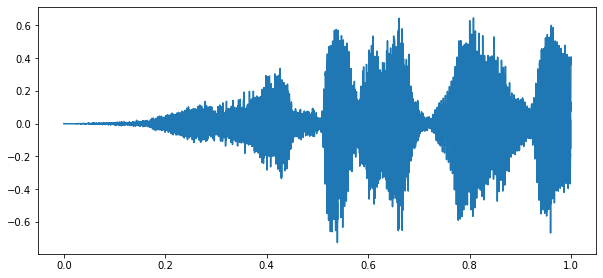

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.linspace(0, 1, sr), data[0, 0:sr])
plt.show()

In [7]:
Audio(data, rate=sr)

# I've always underestimated Fourier-Transform, Cepstrum, etc. However, I've finally understand that this method is simply a feature extraction...
# ...a method that is way necessary when dealing with data where each sample has tons of information.

In [8]:
transformer = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=40, melkwargs={'hop_length': 1024})

d:\Python\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
audio_data = transformer(data)

In [10]:
print(audio_data.size()) # (Channels, Features, N_Timesteps) where Channels = Mono or Stereo, Features = N_MFCC, N_Timesteps = Data/Hop_length

torch.Size([1, 40, 72])


In [12]:
print(audio_data[0, 1].size())

torch.Size([72])


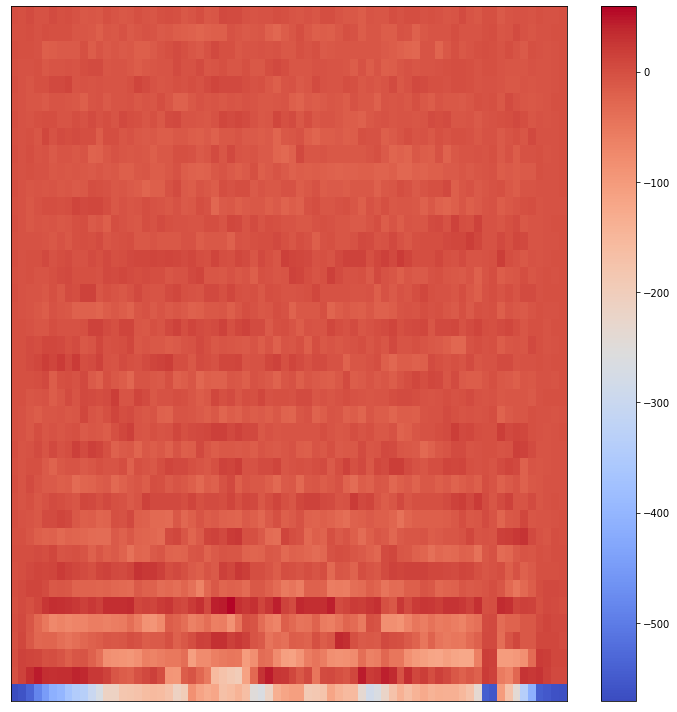

In [13]:
from librosa import display

plt.figure(figsize=(10, 10))
display.specshow(audio_data[0].numpy(), sr=sr)
plt.colorbar()
plt.tight_layout()

plt.show()

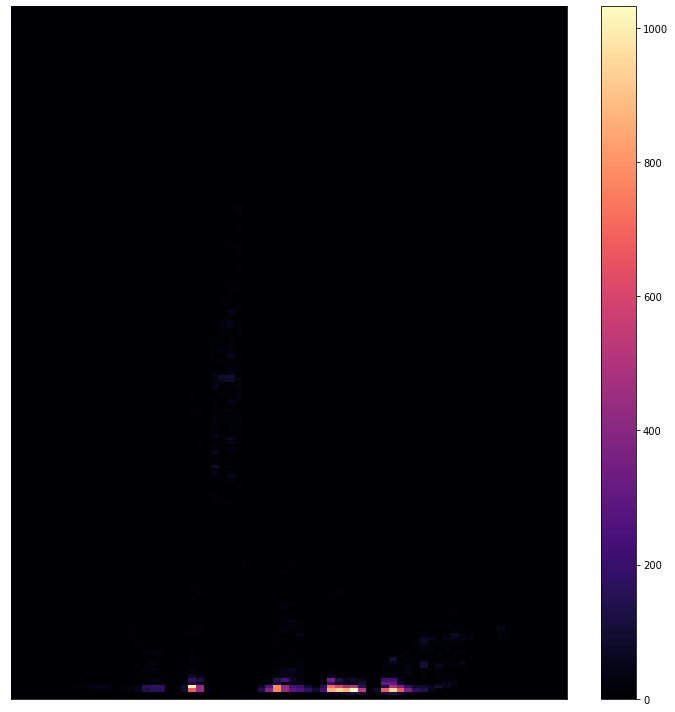

In [17]:
spectrogramer = torchaudio.transforms.Spectrogram(hop_length=1024)
spectrogram = spectrogramer(data)

plt.figure(figsize=(10, 10))
display.specshow(spectrogram[0].numpy(), sr=sr)
plt.colorbar()
plt.tight_layout()

plt.show()

In [33]:
class SpeechToAudioDataset(object):

    def __init__(self, audio_path, text_path, n_features, hop_length):

        self.audio_path = audio_path
        self.text_path = text_path
        self.n_features = n_features
        self.hop_length = hop_length

        self.transformer = torchaudio.transforms.MFCC(sample_rate=44100, n_mfcc=40, melkwargs={'hop_length': 1024})

        self.phrases = self._get_phrases()
        self.words = self._get_words()

        self.dictionary = self._create_dictionary()

        self.audio_data = self._create_audio_data()
        self.text_data = self._create_text_data()

    
    def detokenize(self, data):
        values = list(self.dictionary.values())

        values = np.array(values).reshape(-1,1)

        knn = KNN(n_neighbors=1, algorithm='kd_tree').fit(values)

        _, index = knn.kneighbors(data.reshape(-1,1))

        keys = list(self.dictionary.keys())

        words = []

        for subarray in index:
            for i in subarray:
                words.append(keys[i])

        phrase = ' '.join(words)

        return words, phrase

        

    def __len__(self):

        return len(self.audio_data)

    def __getitem__(self, idx):

        audio = self.audio_data[idx]
        text = self.text_data[idx]

        return audio, text


    def _create_audio_data(self):
        audio_files = []

        for directory, _, files in os.walk(self.audio_path):
            for file in files:
                audio_files.append(directory+'/'+file)

        audio_files = [i for i in audio_files if '.wav' in i]

        audio_data_preprocessed = []

        for audio in audio_files:
            data, sr = torchaudio.load(audio)
            audio_data_preprocessed.append(data.numpy())

        length = [x.shape[1] for x in audio_data_preprocessed]
        maximum_length = max(length)

        audio_data = []
        
        for i in range(len(audio_data_preprocessed)):
            audio = audio_data_preprocessed[i]
            audio_size = audio.shape[1]
            
            if audio_size < maximum_length:
                pad_size = maximum_length - audio_size
                audio = np.pad(audio, [(0, 0), (0, pad_size)])

            audio_data.append(audio)

        audio_data = np.array(audio_data)
        audio_data = np.stack(audio_data, 0)
        audio_data = torch.from_numpy(audio_data)

        transformer = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=self.n_features, melkwargs={'hop_length': self.hop_length})

        audio_dataset = []

        for i in range(len(audio_data)):
            data = transformer(audio_data[i])
            audio_dataset.append(data.numpy())

        audio_dataset = np.array(audio_dataset) # Using Numpy because Pytorch's stack is rubbish
        audio_dataset = np.stack(audio_dataset, 0)

        audio_dataset = torch.from_numpy(audio_dataset)

        # The LSTM expects to receive input with shapes (Batch, Timesteps, Features), so we have to transpose our features and remove the Channels size

        audio_dataset = audio_dataset.view(audio_dataset.size(0), audio_dataset.size(3), audio_dataset.size(2))

        audio_dataset = 2.0*(audio_dataset - torch.min(audio_dataset))/(torch.max(audio_dataset) - torch.min(audio_dataset))-1.0

        print(f"Audio dataset size: {audio_dataset.size()}")

        return audio_dataset

    def _get_phrases(self):
        script_files = []

        for directory, _, files in os.walk(self.text_path):
            for file in files:
                script_files.append(directory+'/'+file)

        script_files = [i for i in script_files if '.txt' in i]

        text_data_preprocessed = []

        for item in script_files:
            file = open(item, 'r')
            for i in file:
                text_data_preprocessed.append(str(i))
    
            file.close()

        text_data_preprocessed = [x.lower() for x in text_data_preprocessed]
        phrases = [re.sub('[^a-z0-9\s\()]', '', x) for x in text_data_preprocessed]

        return phrases

    def _get_words(self):

        words_text = ' '.join(self.phrases)

        words_text = words_text.split(' ')

        return words_text

    def _create_dictionary(self):

        idx2word = []
        word2idx = {}

        for word in self.words:
            if word not in word2idx:
                idx2word.append(word)
                word2idx[word] = len(idx2word) - 1

        word2idx['<EOS>'] = len(idx2word)

        return word2idx

    def _create_text_data(self):
        maximum_length = 0
        for sentence in self.phrases:
            word_length = [len(x) for x in sentence.split()]

            sentence_length = len(word_length)

            if sentence_length > maximum_length:
                maximum_length = sentence_length

        maximum = max(self.dictionary.values())

        for word, value in self.dictionary.items():

            scaled_value = (value-0)*2.0 / (maximum - 0)-1.0

            self.dictionary[word] = scaled_value
        
        phrases = [x.split() for x in self.phrases]
        tokens = []

        for sentence in phrases:
            tokenized_sentence = []

            for word in sentence:
                value = self.dictionary.get(word)

                tokenized_sentence.append(value)

            tokenized_sentence = np.array(tokenized_sentence)
            sentence_size = tokenized_sentence.shape[0]

            if sentence_size < maximum_length:
                pad_size = maximum_length - sentence_size
                tokenized_sentence = np.pad(tokenized_sentence, [(0, pad_size)], constant_values=1.0)

            tokens.append(tokenized_sentence)
        
        tokens = np.array(tokens)

        tokens = torch.from_numpy(tokens)

        print(f"Text Data Size: {tokens.size()}")

        return tokens

In [34]:
AUDIO_PATH = "D:/Python/Audio/English/"
TEXT_PATH = "D:/Python/Audio/Script/"

In [35]:
dataset = SpeechToAudioDataset(AUDIO_PATH, TEXT_PATH, 40, 1024)

d:\Python\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Audio dataset size: torch.Size([149, 334, 40])
Text Data Size: torch.Size([149, 14])


In [36]:
print(dataset.audio_data[0])

tensor([[-0.4080,  0.0904,  0.2509,  ...,  0.3780,  0.4309,  0.2764],
        [-0.0469,  0.5515,  0.4718,  ...,  0.4119,  0.2790,  0.3903],
        [ 0.3893,  0.3944,  0.4967,  ..., -0.4416, -0.4416, -0.4416],
        ...,
        [ 0.7237,  0.7237,  0.7237,  ...,  0.7237,  0.7237,  0.7237],
        [ 0.7237,  0.7237,  0.7237,  ...,  0.7237,  0.7237,  0.7237],
        [ 0.7237,  0.7237,  0.7237,  ...,  0.7237,  0.7237,  0.7237]])


In [37]:
print(dataset.text_data[0])

tensor([-1.0000, -0.9950, -0.9900, -0.9850, -0.9800, -0.9751,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
       dtype=torch.float64)


In [125]:
class Speech2Text(torch.nn.Module):
    def __init__(self):
        super(Speech2Text, self).__init__()

        self.lstm1 = torch.nn.LSTM(40, 14, 3, batch_first=True, bias=False)
        #self.neuron = torch.nn.Linear(14, 14, bias=False)
        #self.tanh = torch.nn.Tanh()

    def forward(self, input):

        x, hidden = self.lstm1(input)

        #print(x.size()) # (batch, n_timesteps, 14)
        #print(hidden[0].size()) # (batch, 10 ,14)

        x = x[:, -1] # Returns only the last output in the output sequence

        #print(x.size())

        #x = self.neuron(x)

        #output = self.tanh(x)
        output = x

        return output # (1, 74, 1)

In [126]:
model = Speech2Text().cuda()

In [127]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss = torch.nn.MSELoss()

In [128]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)

In [129]:
for epoch in range(1000):
    for i, (audio, text) in enumerate(dataloader):
        model.zero_grad()

        input_data = audio.cuda()
        labels = text.cuda().float()

        output = model(input_data)

        #print(output.size())
        #print(labels.size())

        cost = loss(output, labels)

        cost.backward()

        optimizer.step()

    if epoch % 100 == 0:
        print(f"{epoch}/1000\t Current Loss: {cost.item()}")

0/1000	 Current Loss: 0.807129979133606
100/1000	 Current Loss: 0.5869194269180298
200/1000	 Current Loss: 0.24443446099758148
300/1000	 Current Loss: 0.4099462926387787
400/1000	 Current Loss: 0.3482246994972229
500/1000	 Current Loss: 0.1950760930776596
600/1000	 Current Loss: 0.22922374308109283
700/1000	 Current Loss: 0.2368246614933014
800/1000	 Current Loss: 0.2550455331802368
900/1000	 Current Loss: 0.22450315952301025


In [130]:
#print(model.lstm1.weight_ih_l9.grad) # I already have problems with vanishing grads, but in LSTMs...full of tanhs...
print(model.lstm1.weight_ih_l2.grad)

tensor([[ 3.3124e-03,  3.1519e-03,  3.9263e-05, -3.0201e-03, -2.8415e-03,
         -1.9552e-03,  2.5712e-03, -3.0638e-03,  2.8705e-03, -1.5160e-03,
         -3.2216e-03,  1.1046e-03, -1.2186e-03,  2.1921e-03],
        [ 3.0878e-04,  2.9382e-04,  3.6366e-06, -2.8152e-04, -2.6485e-04,
         -1.8224e-04,  2.3965e-04, -2.8560e-04,  2.6759e-04, -1.4172e-04,
         -3.0030e-04,  1.0291e-04, -1.1345e-04,  2.0445e-04],
        [-2.9606e-05, -2.8163e-05, -3.5848e-07,  2.6949e-05,  2.5366e-05,
          1.7440e-05, -2.2930e-05,  2.7356e-05, -2.5567e-05,  1.3263e-05,
          2.8779e-05, -9.8515e-06,  1.0915e-05, -1.9530e-05],
        [-2.8561e-04, -2.7177e-04, -3.3841e-06,  2.6040e-04,  2.4500e-04,
          1.6857e-04, -2.2170e-04,  2.6417e-04, -2.4749e-04,  1.3067e-04,
          2.7778e-04, -9.5238e-05,  1.0508e-04, -1.8900e-04],
        [ 6.4708e-04,  6.1571e-04,  7.6673e-06, -5.8993e-04, -5.5506e-04,
         -3.8197e-04,  5.0225e-04, -5.9849e-04,  5.6065e-04, -2.9583e-04,
         -6.

In [131]:
print(cost.item())

0.3852054178714752


In [132]:
print(output)

tensor([[-0.5111, -0.2286, -0.0700, -0.0335,  0.1242,  0.3400,  0.5729,  0.6457,
          0.7810,  0.8635,  0.9166,  0.9433,  0.9499,  0.9565],
        [-0.5111, -0.2285, -0.0700, -0.0335,  0.1242,  0.3400,  0.5729,  0.6457,
          0.7810,  0.8635,  0.9166,  0.9433,  0.9499,  0.9565],
        [-0.5111, -0.2285, -0.0700, -0.0335,  0.1242,  0.3400,  0.5729,  0.6458,
          0.7810,  0.8635,  0.9166,  0.9433,  0.9499,  0.9565],
        [-0.5111, -0.2286, -0.0700, -0.0335,  0.1242,  0.3400,  0.5729,  0.6458,
          0.7810,  0.8635,  0.9166,  0.9433,  0.9499,  0.9565],
        [-0.5111, -0.2285, -0.0700, -0.0335,  0.1242,  0.3400,  0.5729,  0.6458,
          0.7810,  0.8635,  0.9166,  0.9433,  0.9499,  0.9565]],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [133]:
print(labels)

tensor([[ 0.6858,  0.2519, -0.5262, -0.8953, -0.8454, -0.5960,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.9651, -0.5262, -0.8953, -0.3367,  0.0125, -0.8554,  0.0175, -0.9551,
         -0.7207,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.0374, -0.8753,  0.0424,  0.0474,  0.0524, -0.2569,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.9052,  0.7656,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.0025, -0.9651, -0.0673, -0.8903,  0.0075, -0.9551, -0.2120, -0.3566,
         -0.9950,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]],
       device='cuda:0')


In [134]:
output = output.detach().cpu().numpy()

words, phrase = dataset.detokenize(output)

In [135]:
print(phrase)
print(words)

got late sorry dispatched yourself almost surface beach need scared aware hold away escape got late sorry dispatched yourself almost surface beach need scared aware hold away escape got late sorry dispatched yourself almost surface beach need scared aware hold away escape got late sorry dispatched yourself almost surface beach need scared aware hold away escape got late sorry dispatched yourself almost surface beach need scared aware hold away escape
['got', 'late', 'sorry', 'dispatched', 'yourself', 'almost', 'surface', 'beach', 'need', 'scared', 'aware', 'hold', 'away', 'escape', 'got', 'late', 'sorry', 'dispatched', 'yourself', 'almost', 'surface', 'beach', 'need', 'scared', 'aware', 'hold', 'away', 'escape', 'got', 'late', 'sorry', 'dispatched', 'yourself', 'almost', 'surface', 'beach', 'need', 'scared', 'aware', 'hold', 'away', 'escape', 'got', 'late', 'sorry', 'dispatched', 'yourself', 'almost', 'surface', 'beach', 'need', 'scared', 'aware', 'hold', 'away', 'escape', 'got', 'late

In [136]:
labels = labels.detach().cpu().numpy()

words, phrase = dataset.detokenize(labels)

In [137]:
print(phrase)
print(words)

normal life was not for me <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> i was not even given a chance to judge <EOS> <EOS> <EOS> <EOS> <EOS> there are many lost sheep here <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> its closing <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> no i wont be sent to hell like this <EOS> <EOS> <EOS> <EOS> <EOS>
['normal', 'life', 'was', 'not', 'for', 'me', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', 'i', 'was', 'not', 'even', 'given', 'a', 'chance', 'to', 'judge', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', 'there', 'are', 'many', 'lost', 'sheep', 'here', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', 'its', 'closing', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', 'no', 'i', 'wont', 'be', 'sent', 'to', 'hell', 'like', 'this', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
